## Library

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## Preprocessing: resize slices and csv

In [2]:
# Load training labels
df = pd.read_csv("train_labels.csv")

# Define target size for resizing
target_size = (128, 128)  # (width, height)

# Create a dictionary to store original sizes
original_sizes = {}

# Path to the tomogram slices
train_dir = "train"  

# Loop through each unique tomogram ID to get its original image size
for tomo_id in df["tomo_id"].unique():
    tomo_path = os.path.join(train_dir, tomo_id)
    
    # Get the first image in the tomogram folder
    first_image_path = os.path.join(tomo_path, sorted(os.listdir(tomo_path))[0])
    
    # Read image to get its original dimensions
    img = cv2.imread(first_image_path, cv2.IMREAD_GRAYSCALE)
    orig_height, orig_width = img.shape  # Get original size

    # Store the original size
    original_sizes[tomo_id] = (orig_width, orig_height)

# Now adjust the coordinates in the dataframe
def adjust_coordinates(row):
    orig_width, orig_height = original_sizes[row["tomo_id"]]
    
    scale_x = target_size[0] / orig_width
    scale_y = target_size[1] / orig_height
    
    row["Motor axis 1"] *= scale_y  # Y-axis
    row["Motor axis 2"] *= scale_x  # X-axis
    return row

# Apply coordinate transformation
df = df.apply(adjust_coordinates, axis=1)

# Save updated labels
df.to_csv("train_labels_resized.csv", index=False)
print("✅ Motor coordinates adjusted for resized tomograms!")


✅ Motor coordinates adjusted for resized tomograms!


### Run this once

In [3]:
 # For progress bar
output_dir = "train_resized/"
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through each tomogram folder
for tomo_id in tqdm(os.listdir(train_dir), desc="Resizing tomograms"):
    tomo_path = os.path.join(train_dir, tomo_id)
    output_tomo_path = os.path.join(output_dir, tomo_id)
    
    # Create corresponding output folder
    os.makedirs(output_tomo_path, exist_ok=True)

    # Process each image slice in the tomogram
    for image_name in sorted(os.listdir(tomo_path)):
        image_path = os.path.join(tomo_path, image_name)
        output_image_path = os.path.join(output_tomo_path, image_name)

        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        # Resize image
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # Save resized image
        cv2.imwrite(output_image_path, resized_img)

print("✅ All tomogram slices resized and saved in 'train_resized/'!")

Resizing tomograms: 100%|██████████| 648/648 [18:28<00:00,  1.71s/it]

✅ All tomogram slices resized and saved in 'train_resized/'!


## Visualize + Verify data

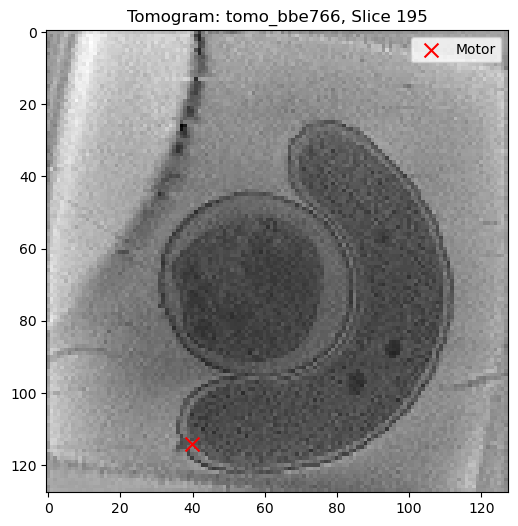

In [17]:
# Load the resized label data
df = pd.read_csv("train_labels_resized.csv")

# Set the path to the resized images
train_resized_dir = "train_resized/"

# Pick a random tomogram that has a motor
random_tomo = random.choice(df["tomo_id"].unique())

# Get the motor locations for this tomogram
motor_locations = df[df["tomo_id"] == random_tomo][["Motor axis 0", "Motor axis 1", "Motor axis 2"]].values

# Get a slice from this tomogram
tomo_path = os.path.join(train_resized_dir, random_tomo)
random_slice_idx = int(motor_locations[0][0])  # Using the first motor's Z-axis as slice index
slice_files = sorted(os.listdir(tomo_path))  # Sorted list of slices
selected_slice = os.path.join(tomo_path, slice_files[random_slice_idx])

# Load the image slice
img = cv2.imread(selected_slice, cv2.IMREAD_GRAYSCALE)

# Plot the image with motor locations
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
for motor in motor_locations:
    if 0 <= motor[0] < len(slice_files):  # Ensure motor is within valid Z-range
        plt.scatter(motor[2], motor[1], color="red", marker="x", s=100, label="Motor")
plt.title(f"Tomogram: {random_tomo}, Slice {random_slice_idx}")
plt.legend()
plt.show()

## Denoising and Contrast Enhancing

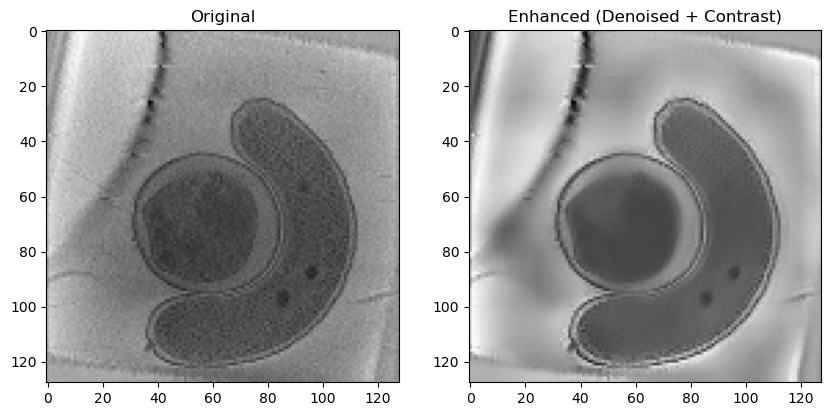

In [18]:
def enhance_image(image_path):
    """Apply denoising and contrast enhancement to a given image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Non-Local Means Denoising (preserves edges while reducing noise)
    denoised = cv2.fastNlMeansDenoising(img, h=7, templateWindowSize=7, searchWindowSize=21)

    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    return enhanced

# Test it on a sample image
test_image_path = selected_slice  # Pick a previously loaded slice
enhanced_img = enhance_image(test_image_path)

# Plot original vs enhanced image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(enhanced_img, cmap="gray")
plt.title("Enhanced (Denoised + Contrast)")
plt.show()

### Run this once

In [19]:
# Define directories
input_dir = "train_resized/"  # Processed images
output_dir = "train_enhanced/"  # Enhanced images

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process all tomograms
for tomo_id in tqdm(os.listdir(input_dir), desc="Enhancing tomograms"):
    tomo_path = os.path.join(input_dir, tomo_id)
    output_tomo_path = os.path.join(output_dir, tomo_id)
    os.makedirs(output_tomo_path, exist_ok=True)

    for image_name in sorted(os.listdir(tomo_path)):
        image_path = os.path.join(tomo_path, image_name)
        output_image_path = os.path.join(output_tomo_path, image_name)

        # Enhance and save image
        enhanced_img = enhance_image(image_path)
        cv2.imwrite(output_image_path, enhanced_img)

print("✅ All images enhanced and saved in 'train_enhanced/'!")


Enhancing tomograms: 100%|██████████| 648/648 [49:30<00:00,  4.58s/it] 

✅ All images enhanced and saved in 'train_enhanced/'!


## Load data

In [2]:
from dataloader import FlagellarMotorDataset

train_labels = pd.read_csv("train_labels_resized.csv")
train_dataset = FlagellarMotorDataset(train_labels, "train_enhanced/", cube_size=16)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

## Define 3D CNN

In [3]:
from cnn3d import LightMotor3DCNN
# ✅ Make sure to define your model first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightMotor3DCNN().to(device)  # Move model to GPU/CPU

# Loss function & optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Train the model

In [4]:
# Training loop
num_epochs = 5  # Adjust based on your dataset size
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for batch_idx, (tomo_tensor, z_labels) in enumerate(train_loader):
        # Move data to GPU/CPU
        tomo_tensor, z_labels = tomo_tensor.to(device), z_labels.to(device)
        if not torch.isfinite(tomo_tensor).all():
            print("⚠️ Warning: NaN or Inf detected in tomo_tensor!")
        if not torch.isfinite(z_labels).all():
            print("⚠️ Warning: NaN or Inf detected in z_labels!")
        z_labels = z_labels.float()
        # Forward pass
        optimizer.zero_grad()  # Clear gradients
        outputs = model(tomo_tensor).squeeze()  # Forward pass
        loss = criterion(outputs, z_labels)  # Compute loss

        # Backward pass
        loss.backward()  # Compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Logging every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Average loss per epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Finished - Avg Loss: {avg_loss:.4f}")

# ✅ Save model after training
torch.save(model.state_dict(), "motor_detector.pth")
print("Training Complete! Model saved as motor_detector.pth")

Epoch [1/5], Batch [10/324], Loss: 0.0000
Epoch [1/5], Batch [20/324], Loss: 0.0000
Epoch [1/5], Batch [30/324], Loss: nan
Epoch [1/5], Batch [40/324], Loss: nan
Epoch [1/5], Batch [50/324], Loss: nan
Epoch [1/5], Batch [60/324], Loss: nan
Epoch [1/5], Batch [70/324], Loss: nan
Epoch [1/5], Batch [80/324], Loss: nan
Epoch [1/5], Batch [90/324], Loss: nan
Epoch [1/5], Batch [100/324], Loss: nan
Epoch [1/5], Batch [110/324], Loss: nan
Epoch [1/5], Batch [120/324], Loss: nan
Epoch [1/5], Batch [130/324], Loss: nan
Epoch [1/5], Batch [140/324], Loss: nan
Epoch [1/5], Batch [150/324], Loss: nan
Epoch [1/5], Batch [160/324], Loss: nan
Epoch [1/5], Batch [170/324], Loss: nan
Epoch [1/5], Batch [180/324], Loss: nan
Epoch [1/5], Batch [190/324], Loss: nan
Epoch [1/5], Batch [200/324], Loss: nan
Epoch [1/5], Batch [210/324], Loss: nan
Epoch [1/5], Batch [220/324], Loss: nan
Epoch [1/5], Batch [230/324], Loss: nan
Epoch [1/5], Batch [240/324], Loss: nan
Epoch [1/5], Batch [250/324], Loss: nan
Epo

: 